**CNN with IMAGE CLASSIFICATION**

In [23]:
import random
import time
import glob
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

**Now we created Dataset.**

3 classes : Drone Airplane Helicopter

In [1]:
#install yolo
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-159-gdb6ec66 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/78.2 GB disk)


Oluşturduğumuz dataseti drive'a yükledik. Drive'dan google colab'e çekmek için kullanmamız gereken kod:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Yüklediğimiz zip dosya uzantılı dataseti zip'ten çıkarmak için:

In [3]:
!unzip -q /content/drive/MyDrive/FIZ437E/dataset.zip -d ../

In [24]:
path_dataset = '/content/drive/MyDrive/FIZ437E/sky-Dataset'

In [32]:
mean_ = torch.tensor([0.490, 0.460, 0.40], dtype=torch.float32)
std_ = torch.tensor([0.230, 0.220, 0.223], dtype=torch.float32)

transform = transforms.Compose([transforms.RandomRotation(5),
                                transforms.Resize(256),
                                transforms.RandomCrop(256, padding=5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_, std=std_)
])

DATASET = torchvision.datasets.ImageFolder(path_dataset, 
                                           transform=transform)

#datasetimizin %85'i train %15 i validation olsun.
len_dataset = len(DATASET)
len_train = round(len(DATASET)*(0.85))
len_validation = round(len(DATASET)*(0.15))

print('Number of all examples: ',len_dataset)
print('Number of training examples: ',len_train)
print('Number of testing examples: ',len_validation)

Number of all examples:  5599
Number of training examples:  4759
Number of testing examples:  840


In [27]:
train_dataset, test_dataset = torch.utils.data.random_split(DATASET, (len_train, len_validation))

train_data = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=24,     # (number of classes + 5 )* 3
                                              shuffle=True,
)

test_data = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=24,
                                              shuffle=False,
)

**Defining CNN Model**

In [28]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 3)
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


CNN =Model()

Custom.yaml dosyamızı Datasetimizle entegre ettik ve class'ları ona göre ayarladık.

**Training for CNN Model**

Using Yolov5 Model (Type of CNN Model)

In [7]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 640 --batch 6 --epochs 20 --data /content/custom.yaml --weights yolov5x.pt --cache

train: weights=yolov5x.pt, cfg=, data=/content/custom.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=20, batch_size=6, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-159-gdb6ec66 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--imgsz IMGSZ [IMGSZ ...]] [--conf-thres CONF_THRES]
                 [--iou-thres IOU_THRES] [--max-det MAX_DET] [--device DEVICE]
                 [--view-img] [--save-txt] [--save-conf] [--save-crop]
                 [--nosave] [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--dnn]
detect.py: error: argument --source: expected one argument


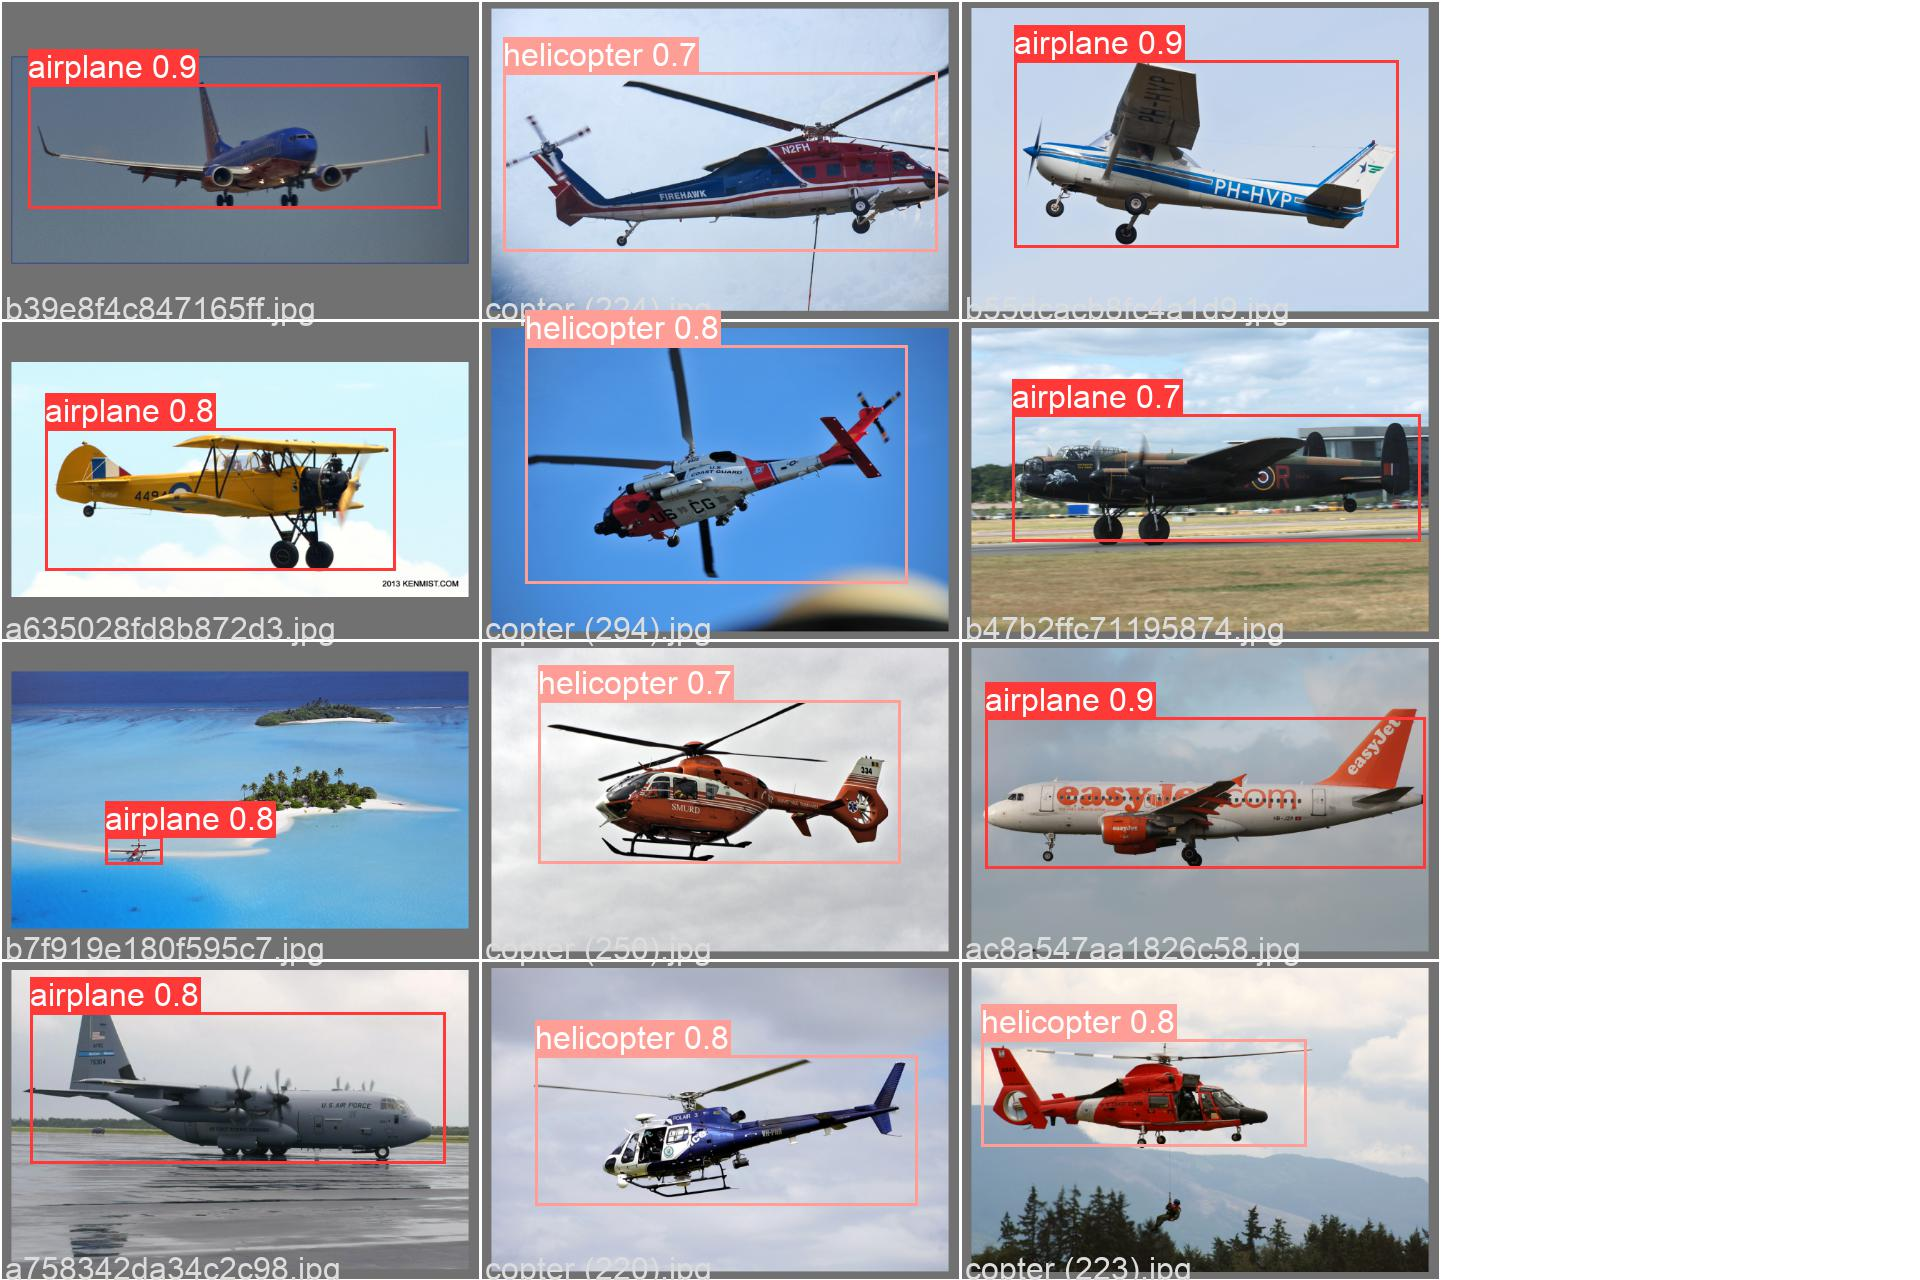

In [22]:
!python detect.py --weights runs/train/exp4/weights/last.pt --img 640 --conf 0.25 --source
display.Image(filename='/content/yolov5/runs/train/exp4/val_batch0_pred.jpg', width=600)

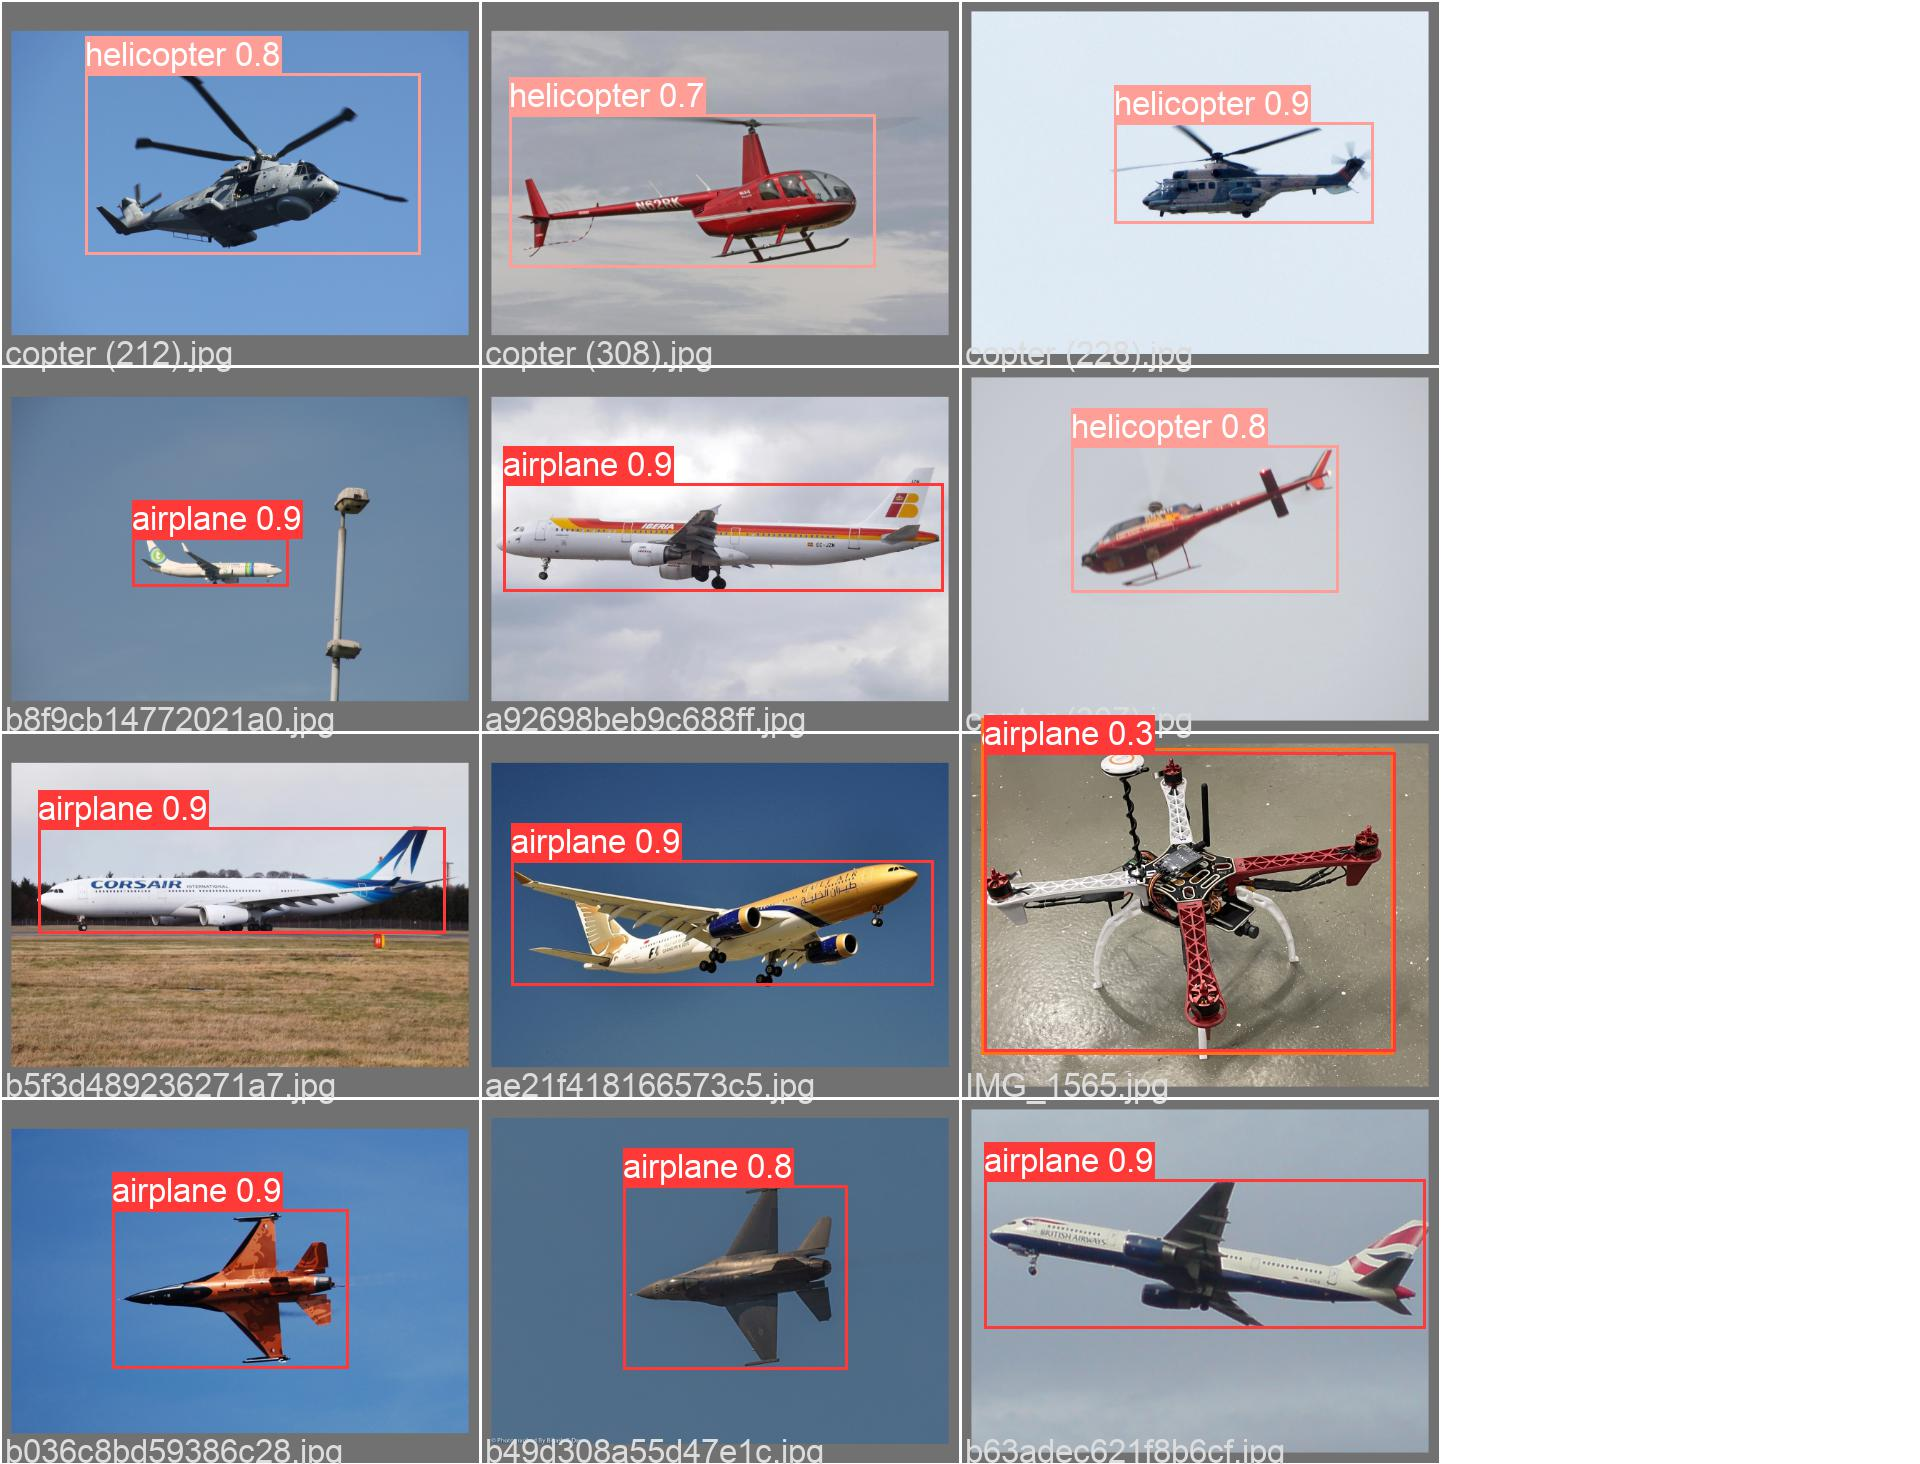

In [20]:
display.Image(filename='/content/yolov5/runs/train/exp4/val_batch1_pred.jpg', width=600)

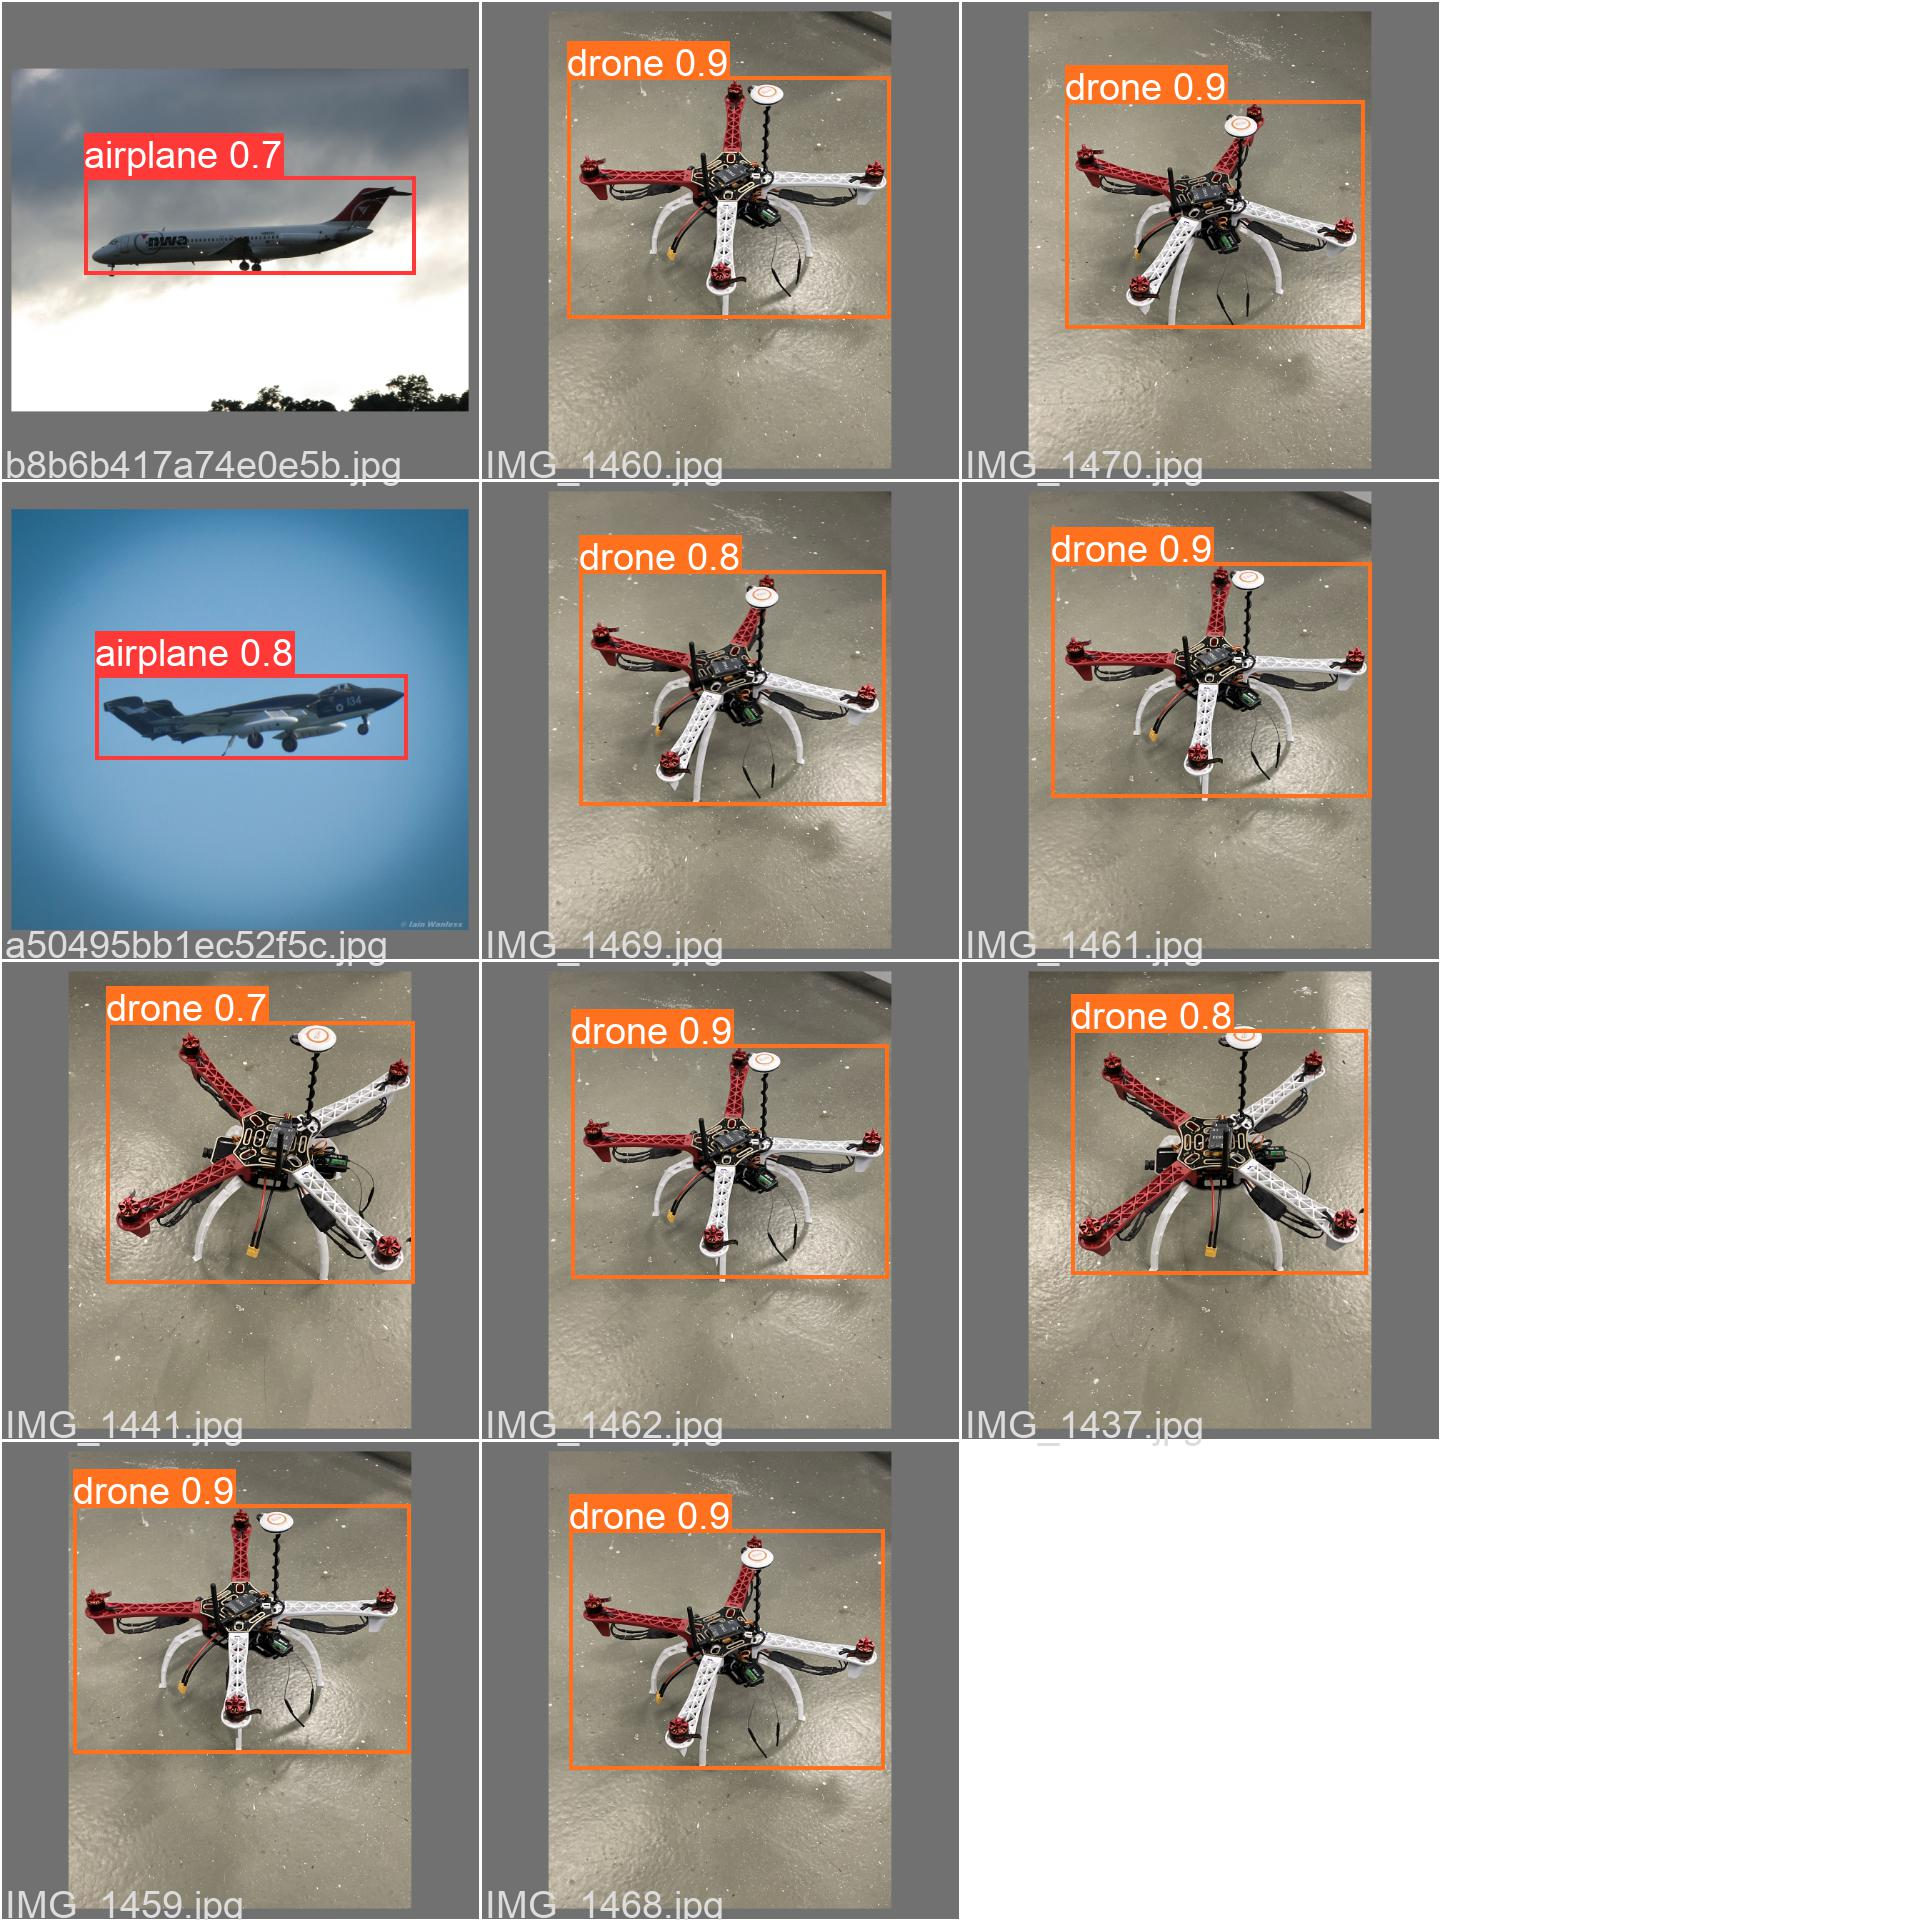

In [21]:
display.Image(filename='/content/yolov5/runs/train/exp4/val_batch2_pred.jpg', width=600)

Dataset içindeki ayarlamarıma göre 0: Airplane, 1:Helicopter, 2:Drone tespitidir.


Bu ayarlamarıma göre tespit başarılı.

Training Curve

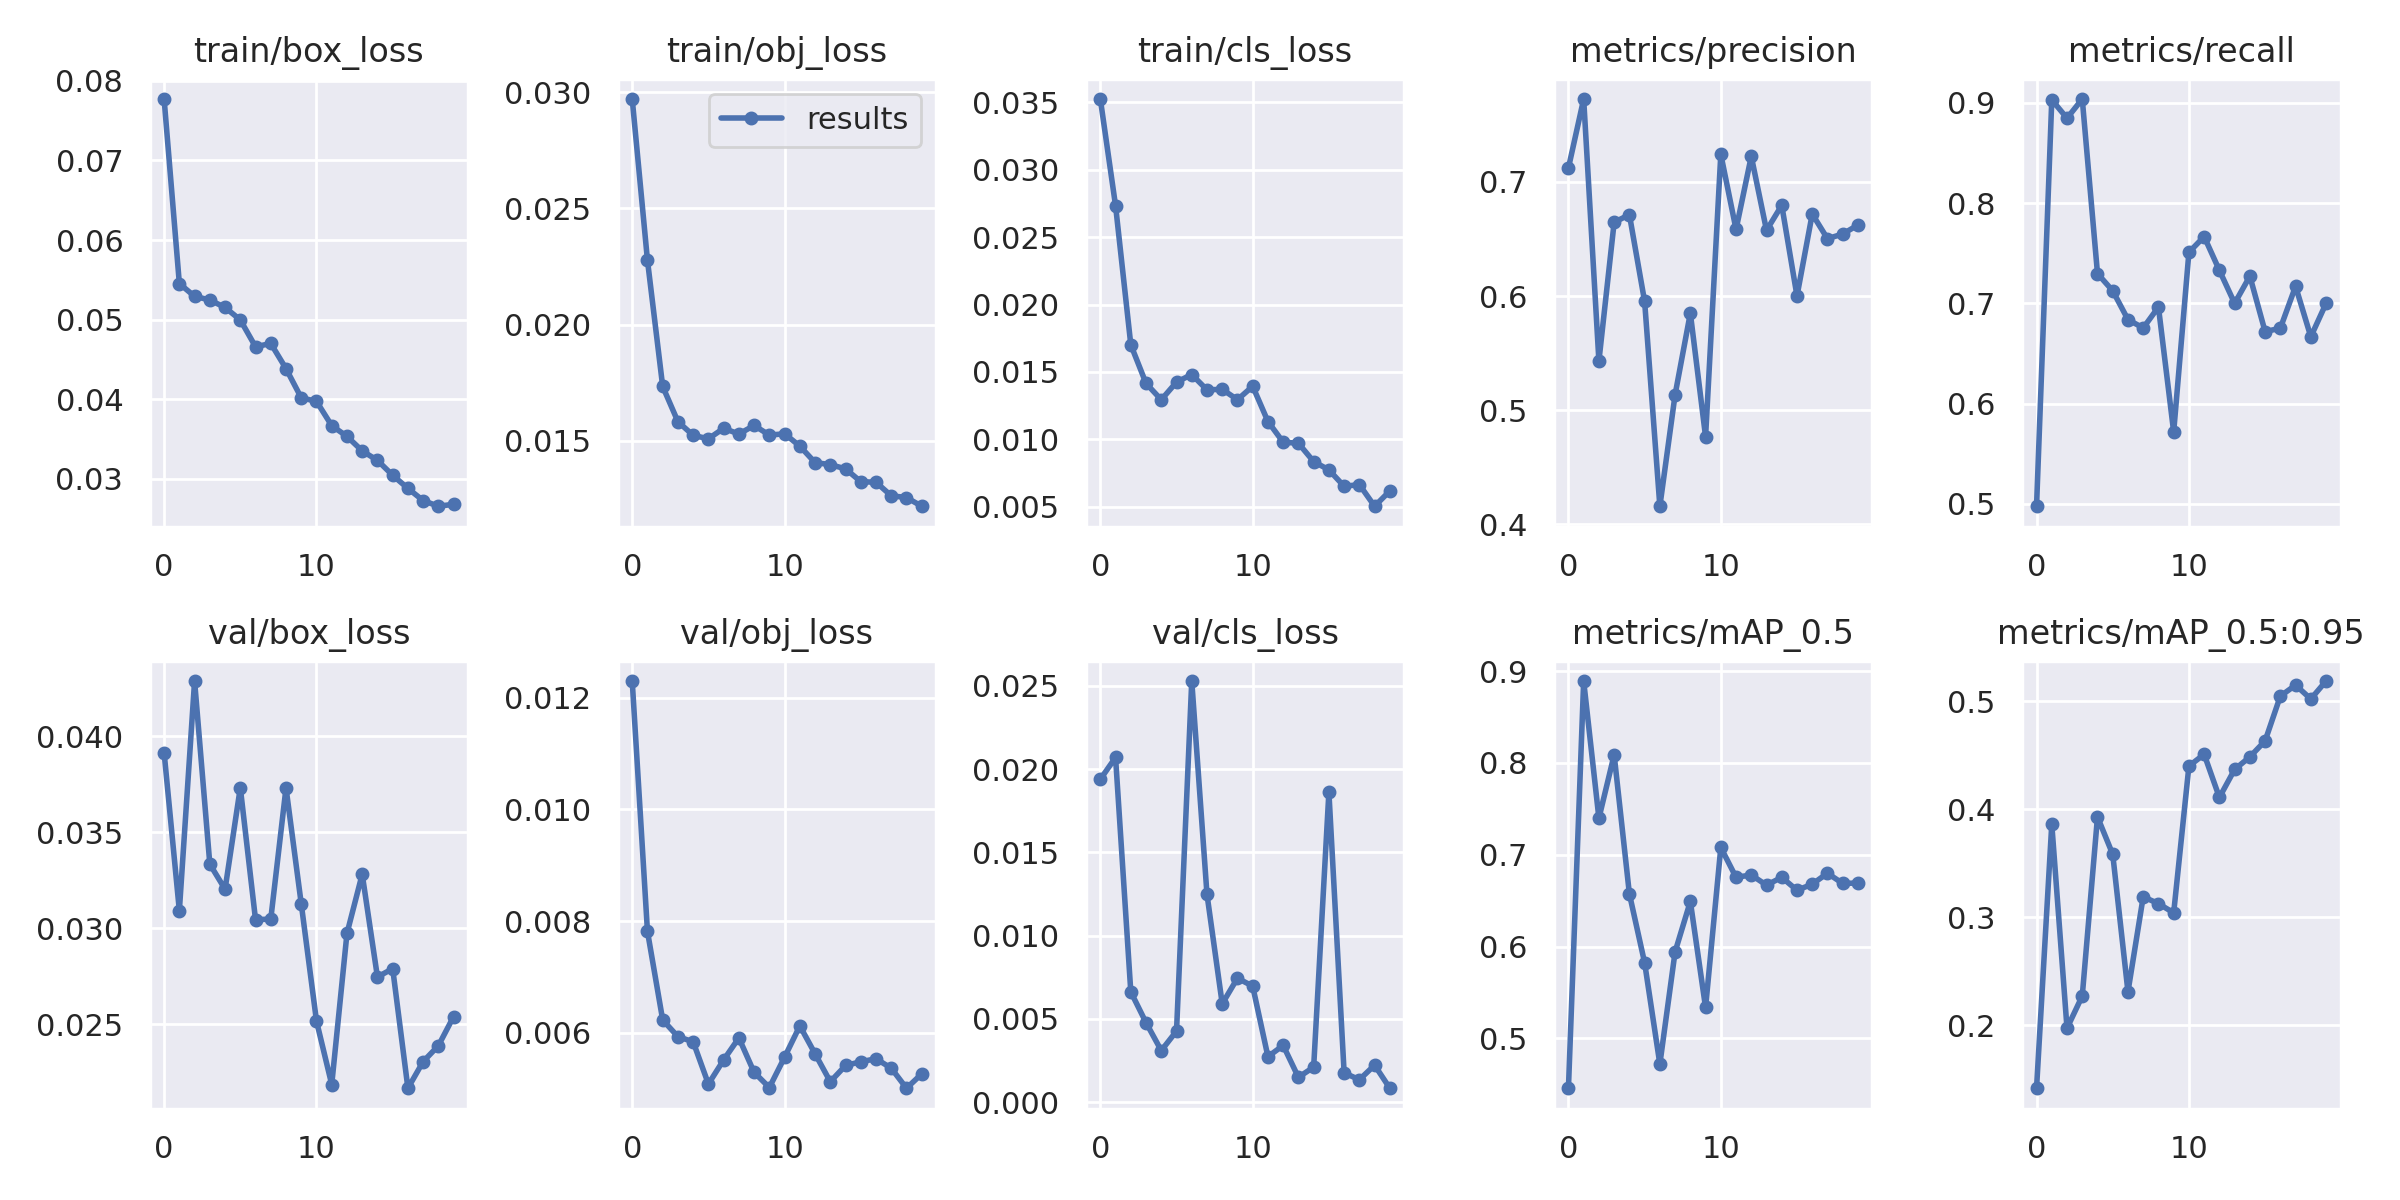

In [16]:
display.Image(filename='/content/yolov5/runs/train/exp4/results.png', width=600)